In [ ]:
import math
import torch
import random
import tarfile
import torchtext
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
import matplotlib.ticker as ticker
from torch.utils.data import Dataset , DataLoader

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
with tarfile.open("/content/drive/MyDrive/MT/training.tar.gz", "r") as tf:
  print("Opened tarfile")
  tf.extractall(path="/content")
  print("All files extracted")

Opened tarfile
All files extracted


In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

In [ ]:
en_tok_model = torchtext.data.utils.get_tokenizer('spacy', language='en_core_web_sm')
de_tok_model = torchtext.data.utils.get_tokenizer('spacy', language='de_core_news_sm')

In [ ]:
def de_tokenizer(sentence):
  return de_tok_model(sentence)

def en_tokenizer(sentence):
  return en_tok_model(sentence)

In [ ]:
class Data():
  def __init__(self, en_filename, de_filename):
    self.en_file = open(en_filename, mode='rt', encoding='utf-8')
    self.en_text = self.en_file.read()
    self.en_file.close()
    self.de_file = open(de_filename, mode='rt', encoding='utf-8')
    self.de_text = self.de_file.read()
    self.de_file.close()
    self.en_text = self.en_text.strip().split('\n')
    self.de_text = self.de_text.strip().split('\n')
  def data(self):
    return self.en_text, self.de_text

In [ ]:
class Vocab():
  def __init__(self, en_filename, de_filename):
    self.en_len = 0
    self.de_len = 0
    self.en_count = Counter()
    self.de_count = Counter()
    self.en_data, self.de_data = Data(en_filename, de_filename).data()
    for idx in range(len(self.en_data)):
      self.en_sent = self.en_data[idx]
      self.de_sent = self.de_data[idx]
      self.en_sent = ['<SOS>'] + en_tokenizer(self.en_sent.lower().strip()) + ['<EOS>']
      self.de_sent = ['<SOS>'] + de_tokenizer(self.de_sent.lower().strip()) + ['<EOS>']
      if(len(self.en_sent) > self.en_len):
        self.en_len = len(self.en_sent)
      if(len(self.de_sent) > self.de_len):
        self.de_len = len(self.de_sent)
      self.en_count.update(self.en_sent)
      self.de_count.update(self.de_sent)
    self.en_vocab = set()
    for k,c in self.en_count.items():
      if len(self.en_vocab)<8190 :
        self.en_vocab.add(k)
    self.en_vocab.add('<PAD>')
    self.de_vocab = set()
    for k,c in self.de_count.items():
      if len(self.de_vocab)<8190 :
        self.de_vocab.add(k)
    self.de_vocab.add('<PAD>')
  def vocab(self):
    return self.en_vocab, self.de_vocab, self.en_len, self.de_len

In [ ]:
class Multi30K(Dataset):
  def __init__(self, en_filename, de_filename):
    self.en_data, self.de_data = Data(en_filename, de_filename).data()
    self.en_vocab, self.de_vocab, self.en_len, self.de_len = Vocab(en_filename, de_filename).vocab()
    self.en_word2idx = {w: idx for (idx, w) in enumerate(self.en_vocab)}
    self.en_word2idx.update({'<UNK>' : len(self.en_word2idx)})
    self.en_idx2word = {idx: w for (idx, w) in enumerate(self.en_vocab)}
    self.en_idx2word.update({len(self.en_idx2word) : '<UNK>'})
    self.de_word2idx = {w: idx for (idx, w) in enumerate(self.de_vocab)}
    self.de_word2idx.update({'<UNK>' : len(self.de_word2idx)})
    self.de_idx2word = {idx: w for (idx, w) in enumerate(self.de_vocab)}
    self.de_idx2word.update({len(self.de_idx2word) : '<UNK>'})

  def __len__(self):
    return len(self.en_data)

  def __getitem__(self, index):
    en_sent = self.en_data[index]
    de_sent = self.de_data[index]
    en_sent = ['<SOS>'] + en_tokenizer(en_sent.lower().strip()) + ['<EOS>']
    de_sent = ['<SOS>'] + de_tokenizer(de_sent.lower().strip()) + ['<EOS>']
    for i in range(len(en_sent)):
      if en_sent[i] in self.en_vocab:
        en_sent[i] = self.en_word2idx[en_sent[i]]
      else:
        en_sent[i] = self.en_word2idx['<UNK>']
    for i in range(len(de_sent)):
      if de_sent[i] in self.de_vocab:
        de_sent[i] = self.de_word2idx[de_sent[i]]
      else:
        de_sent[i] = self.de_word2idx['<UNK>']
    for i in range(len(en_sent), self.en_len):
      en_sent.append(self.en_word2idx['<PAD>'])
    for i in range(len(de_sent), self.de_len):
      de_sent.append(self.de_word2idx['<PAD>'])
    en_sent = torch.tensor(en_sent)
    de_sent = torch.tensor(de_sent)
    return en_sent, de_sent

In [ ]:
class MultiHead_Attn_Layer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout):
        super(MultiHead_Attn_Layer, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads
        self.fc_Q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_K = nn.Linear(hidden_dim, hidden_dim)
        self.fc_V = nn.Linear(hidden_dim, hidden_dim)
        self.fc_O = nn.Linear(hidden_dim, hidden_dim)
        self.scale = math.sqrt(self.head_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        Q = self.fc_Q(query)
        K = self.fc_K(key)
        V = self.fc_V(value)
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        if mask is not None:
            energy = energy.masked_fill(mask == False, -1e10)
        attention = torch.softmax(energy, dim = -1)
        x = torch.matmul(self.dropout(attention), V)
        x = x.permute(0, 2, 1, 3).contiguous()
        out = self.fc_O(x.view(batch_size, -1, self.hidden_dim))
        return out, attention

In [ ]:
class Postn_Feed_Fwrd(nn.Module):
    def __init__(self, hidden_dim, pff_dim, dropout):
        super(Postn_Feed_Fwrd, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, pff_dim)
        self.fc2 = nn.Linear(pff_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        out = torch.relu(self.fc1(input))
        out = self.fc2(self.dropout(out))
        return out

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, max_len=50):
        super().__init__()
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(100, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return X

In [ ]:
class Encoder_Layer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pff_dim, dropout):
        super(Encoder_Layer, self).__init__()
        self.self_attn = MultiHead_Attn_Layer(hidden_dim, n_heads, dropout)
        self.pff = Postn_Feed_Fwrd(hidden_dim, pff_dim, dropout)
        self.attn_norm = nn.LayerNorm(hidden_dim)
        self.pff_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        attn_out, _ = self.self_attn(src, src, src, src_mask)
        inter_out = self.attn_norm(self.dropout(attn_out) + src)
        pff_out = self.pff(inter_out)
        out = self.pff_norm(self.dropout(pff_out) + inter_out)
        return out

In [ ]:
class Encoder(nn.Module):
    def __init__(self, tok_vocab_size, pos_vocab_size, hidden_dim, enc_heads, enc_pff_dim, num_layers, enc_dropout):
        super(Encoder, self).__init__()
        self.tok_embedding = nn.Embedding(tok_vocab_size, hidden_dim)
        self.pos_embedding = PositionalEncoding(num_hiddens=hidden_dim, max_len=50)
        self.enc_layers = nn.ModuleList([Encoder_Layer(hidden_dim, enc_heads, enc_pff_dim, enc_dropout) for i in range(num_layers)])
        self.dropout = nn.Dropout(enc_dropout)

    def forward(self, src, src_mask):
        batch_size = src.shape[0]
        src_len = src.shape[1]
        tok_embed = self.tok_embedding(src)
        pos_embed = self.pos_embedding(tok_embed)
        enc_embed = self.dropout(pos_embed)
        enc_state = enc_embed
        for enc_layer in self.enc_layers:
            enc_state = enc_layer(enc_state, src_mask)
        return enc_state

In [ ]:
class Decoder_Layer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pff_dim, dropout):
        super(Decoder_Layer, self).__init__()
        self.self_attn = MultiHead_Attn_Layer(hidden_dim, n_heads, dropout)
        self.cross_attn = MultiHead_Attn_Layer(hidden_dim, n_heads, dropout)
        self.pff = Postn_Feed_Fwrd(hidden_dim, pff_dim, dropout)
        self.attn_norm1 = nn.LayerNorm(hidden_dim)
        self.attn_norm2 = nn.LayerNorm(hidden_dim)
        self.pff_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, trg_mask, enc_out, src_mask):
        sattn_out, _ = self.self_attn(trg, trg, trg, trg_mask)
        inter_out1 = self.attn_norm1(self.dropout(sattn_out) + trg)
        cattn_out, attn = self.cross_attn(inter_out1, enc_out, enc_out, src_mask)
        inter_out2 = self.attn_norm2(self.dropout(cattn_out) + inter_out1)
        pff_out = self.pff(inter_out2)
        out = self.pff_norm(self.dropout(pff_out) + inter_out2)
        return out, attn

In [ ]:
class Decoder(nn.Module):
    def __init__(self, tok_vocab_size, pos_vocab_size, hidden_dim, dec_heads, dec_pff_dim, num_layers, dec_dropout):
        super(Decoder, self).__init__()
        self.tok_embedding = nn.Embedding(tok_vocab_size, hidden_dim)
        self.pos_embedding = PositionalEncoding(num_hiddens=hidden_dim, max_len=50)
        self.dec_layers = nn.ModuleList([Decoder_Layer(hidden_dim, dec_heads, dec_pff_dim, dec_dropout) for i in range(num_layers)])
        self.fc = nn.Linear(hidden_dim, tok_vocab_size)
        self.scale = math.sqrt(hidden_dim)
        self.dropout = nn.Dropout(dec_dropout)

    def forward(self, trg, trg_mask, enc_out, src_mask):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        tok_embed = self.tok_embedding(trg)
        pos_embed = self.pos_embedding(tok_embed)
        dec_embed = self.dropout(pos_embed)
        dec_state = dec_embed
        for dec_layer in self.dec_layers:
            dec_state, attention = dec_layer(dec_state, trg_mask, enc_out, src_mask)
        out = self.fc(dec_state)
        return out, attention

In [ ]:
class Model(nn.Module):
    def __init__(self, encoder, decoder, src_padding_idx, trg_padding_idx):
        super(Model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_padding_idx = src_padding_idx
        self.trg_padding_idx = trg_padding_idx

    def make_src_mask(self, src):
        src_mask = (src != self.src_padding_idx).unsqueeze(1).unsqueeze(2).to(device)
        return src_mask

    def make_trg_mask(self, trg):
        trg_len = trg.shape[1]
        pad_mask = (trg != self.trg_padding_idx).unsqueeze(1).unsqueeze(2).to(device)
        sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = device)).bool()
        trg_mask = pad_mask & sub_mask
        return trg_mask

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src, src_mask)
        output, attention = self.decoder(trg, trg_mask, enc_out, src_mask)
        return output, attention

In [ ]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 2}

In [ ]:
dataset = Multi30K('/content/train.en', '/content/train.de')
data = DataLoader(dataset, **params)

In [ ]:
NUM_EPOCHS = 10
SRC_VOCAB_SIZE = len(dataset.en_vocab)+1
TRG_VOCAB_SIZE = len(dataset.de_vocab)+1
HIDDEN_DIM = 256
ENC_PFF_DIM = 512
DEC_PFF_DIM = 512
ENC_HEADS = 8
DEC_HEADS = 8
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3
ENC_NUM_LAYERS = 3
DEC_NUM_LAYERS = 3
MAX_LEN = 50

In [ ]:
src_padding_idx = dataset.en_word2idx["<PAD>"]
trg_padding_idx = dataset.de_word2idx["<PAD>"]

In [ ]:
encoder = Encoder(SRC_VOCAB_SIZE, MAX_LEN, HIDDEN_DIM, ENC_HEADS, ENC_PFF_DIM, ENC_NUM_LAYERS, ENC_DROPOUT).to(device)
decoder = Decoder(TRG_VOCAB_SIZE, MAX_LEN, HIDDEN_DIM, DEC_HEADS, DEC_PFF_DIM, DEC_NUM_LAYERS, DEC_DROPOUT).to(device)
model = Model(encoder, decoder, src_padding_idx, trg_padding_idx).to(device)
criterion = nn.CrossEntropyLoss(ignore_index = trg_padding_idx)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
train_loss, train_perplexity = [], []
valid_loss, valid_perplexity = [], []
for epoch in range(10):
  epoch_loss = 0
  for t, (en,de) in enumerate(data):
    if t < 453:
      en = en.to(device)
      de = de.to(device)
      out, _ = model(en, de[:,:-1])
      out = out.contiguous().view(-1, out.shape[-1])
      loss = criterion(out, de[:, 1:].contiguous().view(-1))
      epoch_loss += float(loss)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    else:
      en = en.to(device)
      de = de.to(device)
      out, _ = model(en, de[:,:-1])
      out = out.contiguous().view(-1, out.shape[-1])
      loss = criterion(out, de[:, 1:].contiguous().view(-1))

  valid_loss.append(float(loss))
  train_loss.append(epoch_loss/len(data))
  valid_perplexity.append(float(torch.exp(loss)))
  train_perplexity.append(math.exp(epoch_loss/len(data)))
  print("-"*25, f"Epoch {epoch + 1}","-"*25)
  print("Train Loss : ", round(train_loss[-1],3), "Train Perplexity : ", round(train_perplexity[-1],3))
  print("Valid Loss : ", round(valid_loss[-1],3), "Valid Perplexity : ", round(valid_perplexity[-1],3))

------------------------- Epoch 1 -------------------------
Train Loss :  3.741 Train Perplexity :  42.157
Valid Loss :  3.531 Valid Perplexity :  34.148
------------------------- Epoch 2 -------------------------
Train Loss :  2.744 Train Perplexity :  15.554
Valid Loss :  1.967 Valid Perplexity :  7.151
------------------------- Epoch 3 -------------------------
Train Loss :  2.378 Train Perplexity :  10.78
Valid Loss :  1.932 Valid Perplexity :  6.903
------------------------- Epoch 4 -------------------------
Train Loss :  2.138 Train Perplexity :  8.479
Valid Loss :  2.745 Valid Perplexity :  15.564
------------------------- Epoch 5 -------------------------
Train Loss :  1.959 Train Perplexity :  7.089
Valid Loss :  2.367 Valid Perplexity :  10.666
------------------------- Epoch 6 -------------------------
Train Loss :  1.825 Train Perplexity :  6.201
Valid Loss :  1.466 Valid Perplexity :  4.331
------------------------- Epoch 7 -------------------------
Train Loss :  1.716 Tra

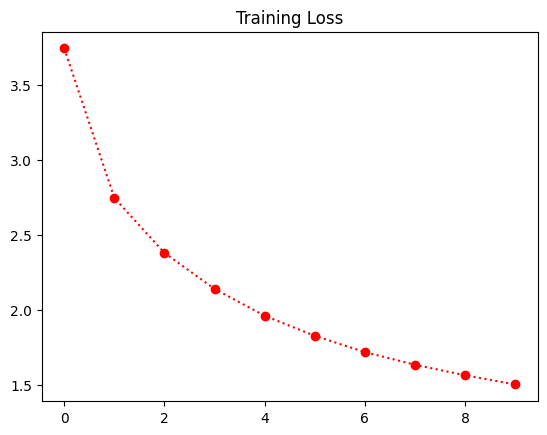

In [ ]:
plt.plot(train_loss, 'o:r')
plt.title("Training Loss")
plt.show()

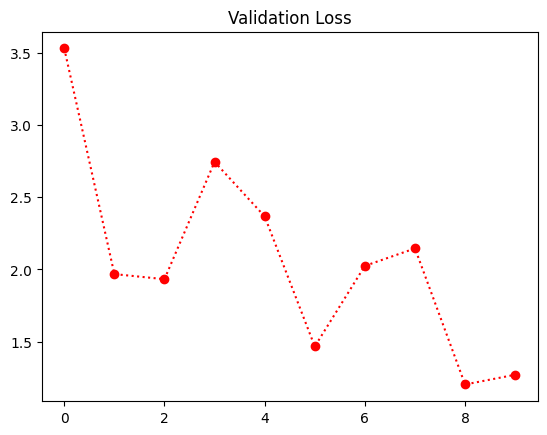

In [ ]:
plt.plot(valid_loss, 'o:r')
plt.title("Validation Loss")
plt.show()

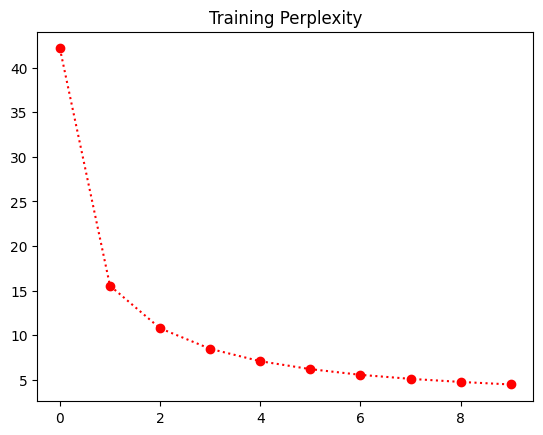

In [ ]:
plt.plot(train_perplexity, 'o:r')
plt.title("Training Perplexity")
plt.show()

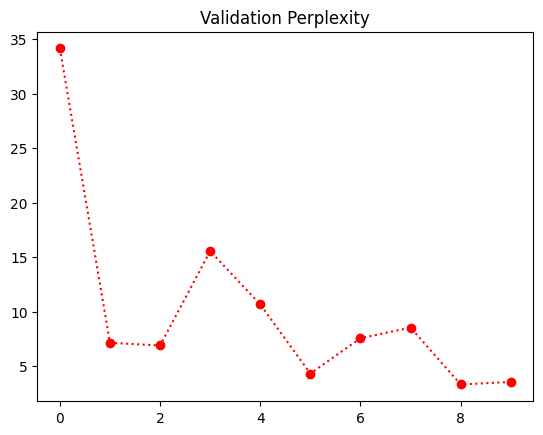

In [ ]:
plt.plot(valid_perplexity, 'o:r')
plt.title("Validation Perplexity")
plt.show()

In [ ]:
def Translate(src_sentence, model):
    src_mask = model.make_src_mask(src_sentence)
    with torch.no_grad():
        enc_out = model.encoder(src_sentence, src_mask)
    sos_id = dataset.de_word2idx['<SOS>']
    eos_id = dataset.de_word2idx['<EOS>']
    predicts = [sos_id]
    for i in range(50):
        input = torch.LongTensor(predicts).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(input)
        with torch.no_grad():
            output, attention = model.decoder(input, trg_mask, enc_out, src_mask)
        predict_tok = output.argmax(2)[:, -1].item()
        predicts.append(predict_tok)
        if predict_tok == eos_id:
            break
    sentence = [dataset.de_idx2word[id] for id in predicts]
    return sentence, attention

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def CalcBELU(model, dataset):
  belu_score = 0
  for n in range(1,9):
    true_translation = []
    (en,de) = dataset[-n]
    en = en.resize_(1,en.size(0)).to(device)
    pred_translation, attn = Translate(en, model)
    for id in de:
      if id != dataset.de_word2idx['<PAD>']:
        true_translation.append(dataset.de_idx2word[int(id)])
    belu_score += float(sentence_bleu([pred_translation], true_translation))
  return belu_score/8

In [ ]:
print("Obtained BELU Score : ", CalcBELU(model, dataset)*100)

Obtained BELU Score :  38.468927510341054


In [ ]:
txt = input("Enter A Text : ")
eng = en_tokenizer(txt.lower().strip())
txt = en_tokenizer(txt.lower().strip())
for i in range(len(txt)):
  if txt[i] in dataset.en_vocab:
    txt[i] = dataset.en_word2idx[txt[i]]
  else:
    txt[i] = dataset.en_word2idx['<UNK>']
txt = torch.tensor(txt)
txt.resize_(1, len(txt))
txt = txt.to(device)
ger, attend = Translate(txt, model)
print(ger)

Enter A Text : A person riding a bike on a snowy road.
['<SOS>', 'eine', 'person', 'fährt', 'skateboard', 'auf', 'einer', 'verschneiten', 'straße', '.', '<EOS>']


In [ ]:
def Disp_Attn(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    assert n_rows * n_cols == n_heads
    fig = plt.figure(figsize=(15,25))
    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        cax = ax.matshow(_attention, cmap='bone')
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<SOS>']+[t.lower() for t in sentence]+['<EOS>'], rotation=45)
        ax.set_yticklabels(['']+translation)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    plt.close()

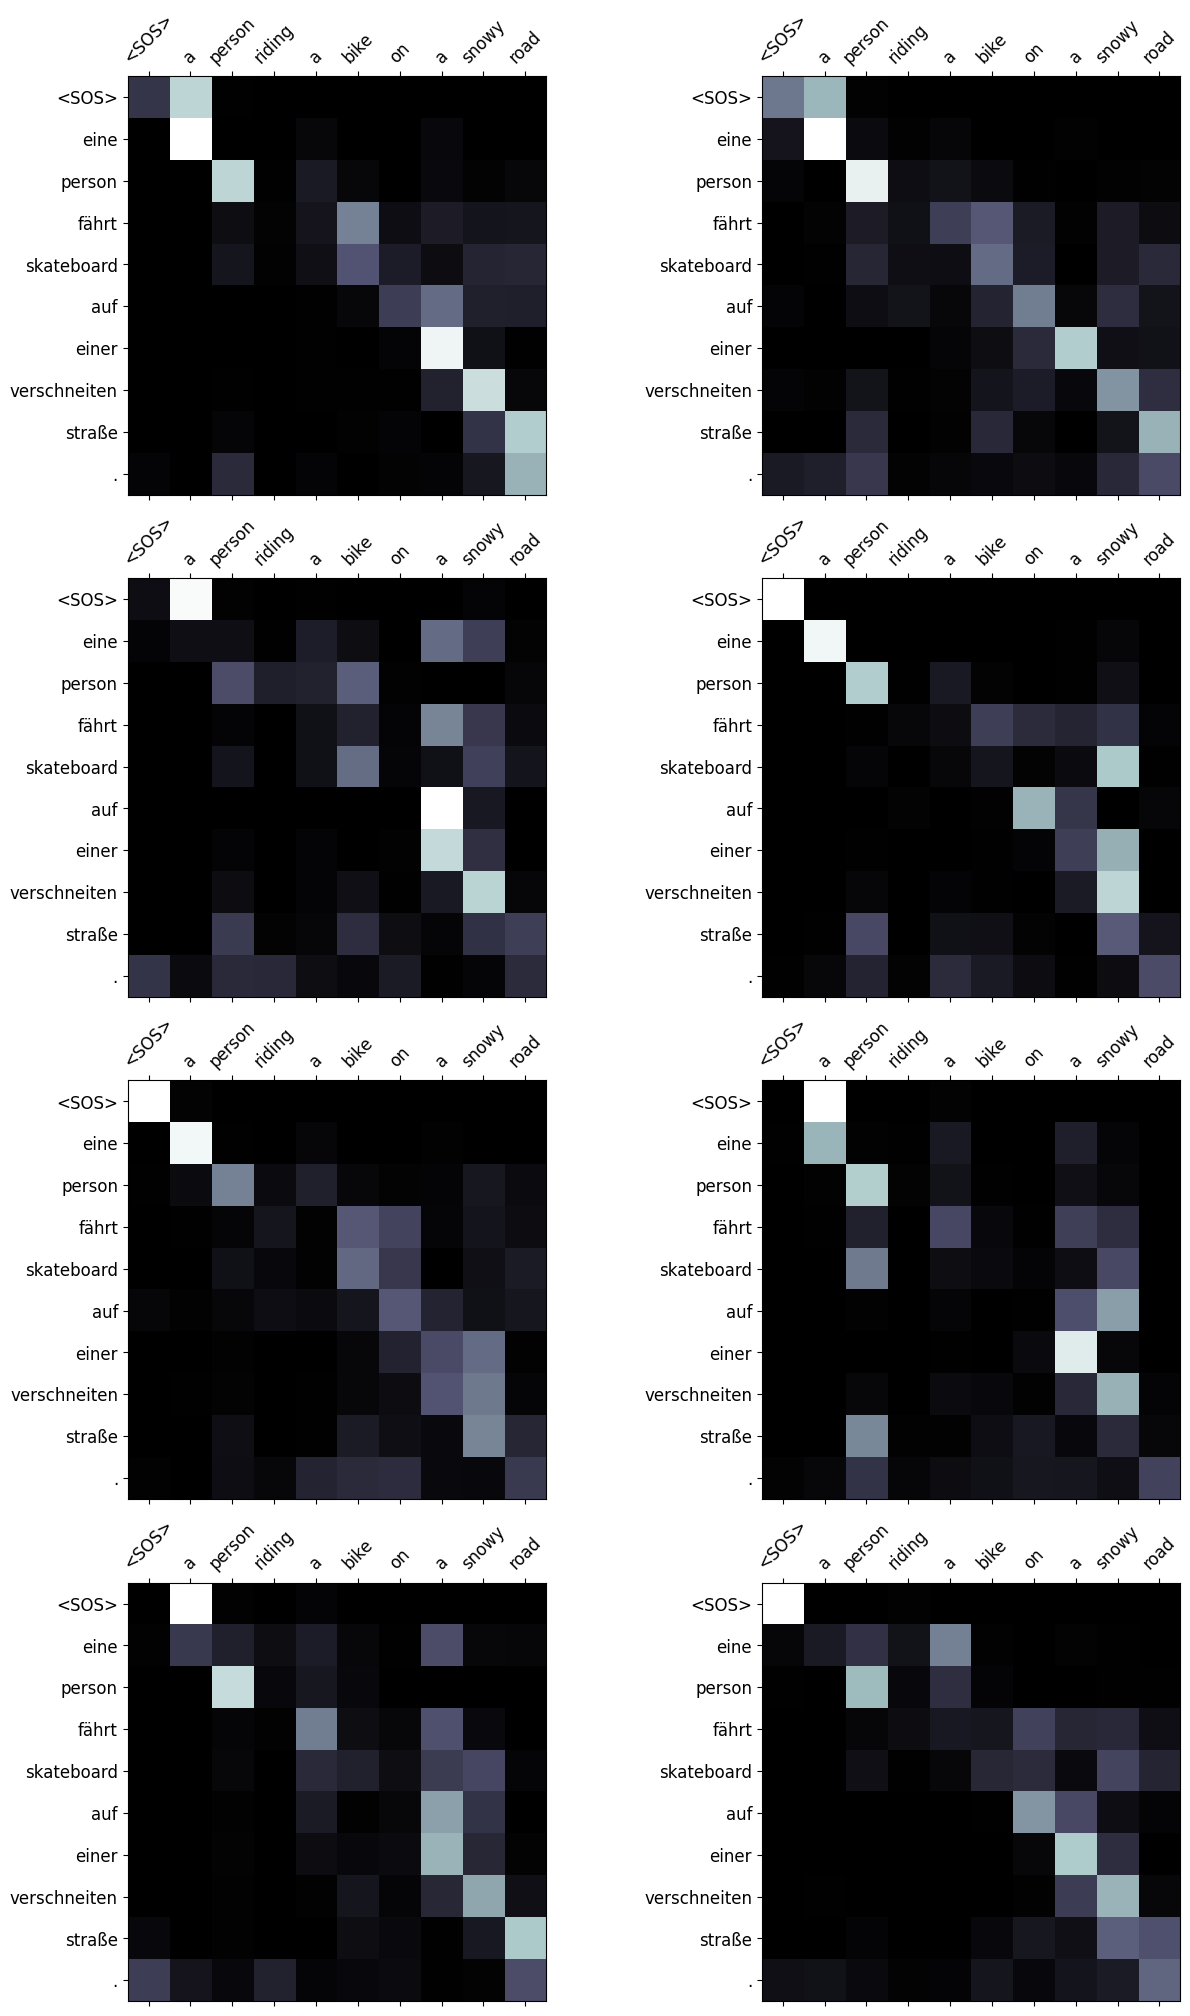

In [ ]:
Disp_Attn(eng, ger, attend)